# Reading XML models

This tutorial shows how to read ctools XML compatible files and transform it gammapy.models.


This include point source, Gaussian, Disk, Shell and 2D and 3D fits file.

### WARNING: As there is no SKyCoord frame attached to the Map, the source coordinate model and the fits file need to be in the same frame (CEL or GAL).

## Imports and versions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
import tempfile
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.utils.random import get_random_state
from gammapy.cube import (
    make_map_exposure_true_energy,
    SkyModel,
    SkyModelMapFit,
    SkyModelMapEvaluator,
    SourceLibrary,
    PSFKernel,
)

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy 
	version                : 0.8.dev6119 
	githash                : c255ddf95520b5bc1ec56bb4f7b0cfd11d38ab87 



In [4]:
# Load CTA IRFs

def get_irfs():
    filename = '$GAMMAPY_EXTRA/datasets/cta-1dc/caldb/data/cta//1dc/bcf/South_z20_50h/irf_file.fits'
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
    aeff = EffectiveAreaTable2D.read(filename, hdu='EFFECTIVE AREA')
    edisp = EnergyDispersion2D.read(filename, hdu='ENERGY DISPERSION')
    bkg = Background3D.read(filename, hdu='BACKGROUND')
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)

irfs = get_irfs()

In [6]:
# Read the skymodel from an XML file
with tempfile.NamedTemporaryFile() as xml_file:
    xml_file.write(b'''<?xml version="1.0" encoding="utf-8"?>
    <source_library title="source library">
        <source name="Source 1" type="PointSource">
            <spectrum type="PowerLaw">
                <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10" />
                <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
                <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
            </spectrum>
            <spatialModel type="PointSource">
                <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="259.34"/>
                <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-40.53"/>
            </spatialModel>
        </source>
        <source name="Source 2" type="RadialGaussian">
            <spectrum type="PowerLaw">
                <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10" />
                <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
                <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
            </spectrum>
            <spatialModel type="RadialGaussian">
                <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="257.22"/>
                <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-38.89"/>
                <parameter free="1" max="10" min="0.01" name="Sigma" scale="1" value="0.2"/>
            </spatialModel>
        </source>
        <source name="Source 3" type="RadialDisk">
            <spectrum type="ExponentialCutoffPowerLaw">
                <parameter name="Prefactor" value="2.5" error="0" scale="1e-17" min="1e-07" max="1000" free="1" />
                <parameter name="Index" value="-2.1" error="0" scale="1" min="0" max="-5" free="1" />
                <parameter name="CutoffEnergy" value="1" error="0" scale="1000000" min="0.01" max="1000" free="1" />
                <parameter name="PivotEnergy" value="1" scale="1000000" min="0.01" max="1000" free="0" />
            </spectrum>
            <spatialModel type="RadialDisk">
                <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="260.29"/>
                <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-38.72"/>
                <parameter free="1" max="10" min="0.01" name="Radius" scale="1" value="0.3"/>                
            </spatialModel>
        </source>
        <source name="Source 4" type="RadialShell">
            <spectrum type="PowerLaw">
                <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10" />
                <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
                <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
            </spectrum>
            <spatialModel type="RadialShell">
                <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="256.0"/>
                <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-40.18"/>
                <parameter free="1" max="10" min="0.01" name="Radius" scale="1" value="0.5"/>                
                <parameter free="1" max="10" min="0.01" name="Width" scale="1" value="0.1"/>                
            </spatialModel>
        </source>
        <source name="RXJ1713" type="DiffuseSource">
            <spectrum type="ExponentialCutoffPowerLaw">
                <parameter name="Prefactor" scale="1e-17" value="2.3" min="1e-07" max="1000.0" free="1"/>
                <parameter name="Index" scale="-1" value="2.06" min="0.0" max="+5.0" free="1"/>
                <parameter name="PivotEnergy" scale="1e6" value="1.0" min="0.01" max="1000.0" free="0"/>
                <parameter name="CutoffEnergy" scale="1e6" value="12.9" min="0.01" max="1000.0" free="1"/>
            </spectrum>
            <spatialModel type="DiffuseMap" file="$GAMMAPY_EXTRA/datasets/catalogs/fermi/Extended_archive_v18/Templates/RXJ1713_2016_250GeV.fits">
                <parameter name="Prefactor" value="1" scale="1" min="0.001" max="1000" free="0"/>
            </spatialModel>
        </source>
        <source name="IEM" type="DiffuseSource">
            <spectrum type="ConstantValue">
                <parameter name="Value" value="1" error="0" scale="1" min="1e-05" max="100000" free="1" />
            </spectrum>
            <spatialModel type="MapCubeFunction" file="$GAMMAPY_EXTRA/datasets/vela_region/gll_iem_v05_rev1_cutout.fits">
                <parameter name="Normalization" value="1" scale="1" min="0.001" max="1000" free="0" />
            </spatialModel>
        </source>       
    </source_library>
    ''')
    xml_file.seek(0)
    sourcelib = SourceLibrary.from_xml(xml_file.name)

sky_model = sourcelib.skymodels
print(sky_model)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[SkyModel(spatial_model=<gammapy.image.models.new.SkyPointSource object at 0x11463bac8>, spectral_model=PowerLaw()), SkyModel(spatial_model=<gammapy.image.models.new.SkyGaussian object at 0x114d520b8>, spectral_model=PowerLaw()), SkyModel(spatial_model=<gammapy.image.models.new.SkyDisk object at 0x114d52908>, spectral_model=ExponentialCutoffPowerLaw()), SkyModel(spatial_model=<gammapy.image.models.new.SkyShell object at 0x115b2b240>, spectral_model=PowerLaw()), SkyModel(spatial_model=<gammapy.image.models.new.SkyDiffuseMap object at 0x105259fd0>, spectral_model=ExponentialCutoffPowerLaw()), SkyModel(spatial_model=<gammapy.image.models.new.SkyDiffuseMap object at 0x115b2e8d0>, spectral_model=ConstantModel())]


In [7]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV',
)
geom = WcsGeom.create(
    skydir=(258.4, -39.7), binsz=0.02, width=(10, 5),
    coordsys='CEL', axes=[axis],
)

In [8]:
# Define some observation parameters
# Here we just have a single observation,
# we are not simulating many pointings / observations
pointing = SkyCoord(258.4, -39.7, unit='deg', frame='icrs')
livetime = 10 * u.hour
offset_max = 4 * u.deg
offset = Angle('2 deg')

In [9]:
# Compute maps, PSF and EDISP - just as you would for analysis of real data

# Exposure
exposure_map = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs['aeff'],
    ref_geom=geom, offset_max=offset_max,
)

# PSF
psf = irfs['psf'].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf,
                                      geom,
                                      max_radius=1 * u.deg)

# EDISP : TODO
edisp = irfs['edisp'].to_energy_dispersion(offset=offset)

# Background : TODO

/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


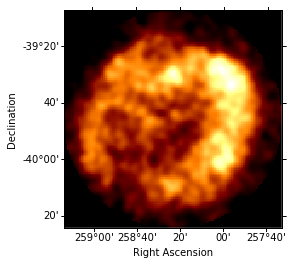

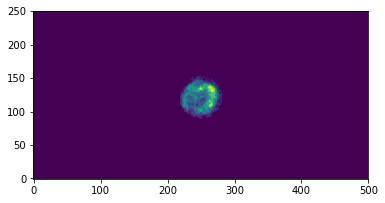

In [10]:
s=sky_model[-1]
s.spatial_model._map.plot() ; plt.show()


evaluator = SkyModelMapEvaluator(sky_model=s, 
                                 exposure=exposure_map)

# Accessing and saving a lot of the following maps is for debugging.
# Just for a simulation one doesn't need to store all these things.
#dnde = evaluator.compute_dnde()
#flux = evaluator.compute_flux()

npred = evaluator.compute_npred()
plt.imshow(npred.sum(axis=0))

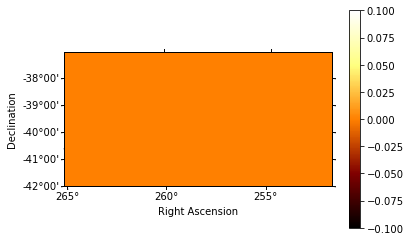

/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


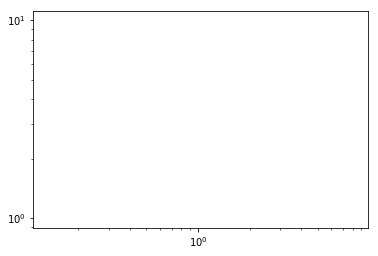

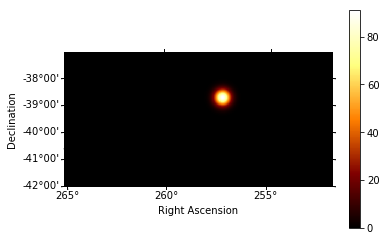

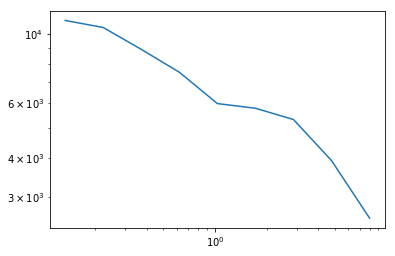

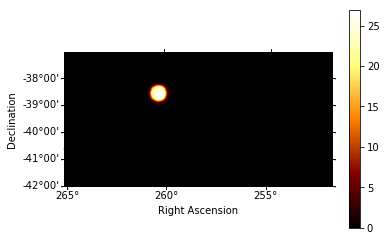

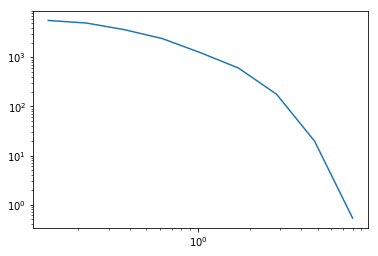

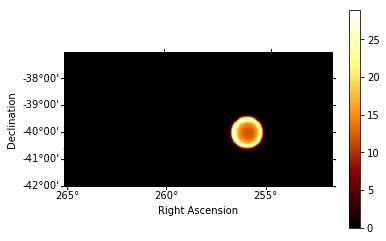

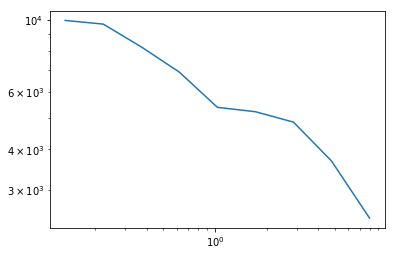

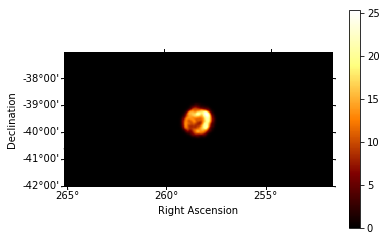

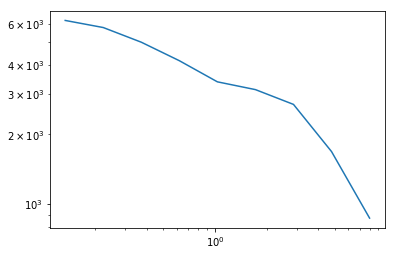

In [13]:
# The idea is that we have this class that can compute `npred`
# maps, i.e. "predicted counts per pixel" given the model and
# the observation infos: exposure, background, PSF and EDISP

npred_map=WcsNDMap.from_geom(geom)

#TODO: SkyPointSource returns a blank image
for model in sky_model[:]:

    evaluator = SkyModelMapEvaluator(sky_model=model, 
                                     exposure=exposure_map,
                                     psf=psf_kernel)

    # Accessing and saving a lot of the following maps is for debugging.
    # Just for a simulation one doesn't need to store all these things.
    #dnde = evaluator.compute_dnde()
    #flux = evaluator.compute_flux()

    npred = evaluator.compute_npred()
    npred_map_ = WcsNDMap(geom, npred)
    npred_map.data = npred_map.data + npred_map_.data
    npred_map_.sum_over_axes().plot(add_cbar=True)
    plt.show()
    plt.loglog(axis.center, npred_map_.data.sum(axis=(1,2)))
    plt.show()

(<matplotlib.figure.Figure at 0x1265077b8>,
 <matplotlib.colorbar.Colorbar at 0x126457240>)

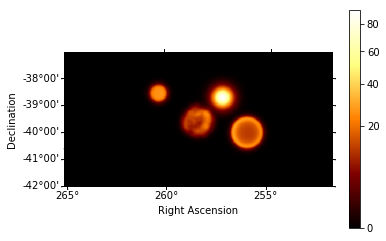

In [14]:
npred_map.sum_over_axes().plot(add_cbar=True,stretch='sqrt')

In [15]:
# The npred map contains negative values, this is probably a bug in the PSFKernel application
npred_map.data[npred_map.data<0] = 0

In [16]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = get_random_state(42)
counts = rng.poisson(npred_map.data)
counts_map = WcsNDMap(geom, counts)

(<matplotlib.figure.Figure at 0x12481e470>,
 None)

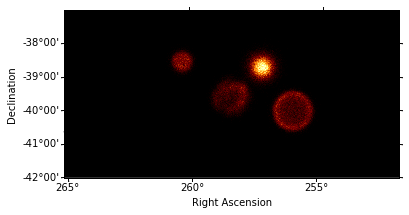

In [17]:
counts_map.sum_over_axes().plot()